# PyTerrier Notebook for Full-Rank Submissions

This notebook serves as a baseline full-rank submission for [TIRA](https://tira.io)/[TIREx](https://tira.io/tirex) that builds a PyTerrier index and subsequently creates a run with BM25.

### Step 1: Ensure Libraries are Imported

In [1]:
import os

# Detect if we are in the TIRA sandbox
# Install the required dependencies if we are not in the sandbox.
if 'TIRA_DATASET_ID' not in os.environ:
    !pip3 install  python-terrier tira==0.0.88 ir_datasets
    !pip3 install -q python-terrier
    !pip3 install -q --upgrade git+https://github.com/terrierteam/pyterrier_t5.git
else:
    print('We are in the TIRA sandbox.')

from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run

# PyTerrier must be imported after the call to ensure_pyterrier_is_loaded in TIRA.
import pyterrier as pt

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 996.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 1.6 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 39.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.1 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ensure Pyterrier integration is loaded

In [2]:
ensure_pyterrier_is_loaded()

Due to execution in TIRA, I have patched ir_datasets to always return the single input dataset mounted to the sandbox.
Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True
terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /home/codespace/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /home/codespace/.pyterrier...
Done
terrier-prf -SNAPSHOT jar not found, downloading to /home/codespace/.pyterrier...
Done


PyTerrier 0.10.0 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


### Step 2: Load data, create index

In [3]:
dataset = pt.get_dataset('irds:ir-lab-jena-leipzig-wise-2023/validation-20231104-training')
qrels = dataset.get_qrels()
topics = dataset.get_topics(variant="title")

index_loc = "./index"
indexer = pt.IterDictIndexer(index_loc)
indexref = indexer.index(dataset.get_corpus_iter())

Load ir_dataset "ir-lab-jena-leipzig-wise-2023/validation-20231104-training" from tira.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents:   0%|          | 1/61307 [00:00<3:38:28,  4.68it/s]

No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents: 100%|██████████| 61307/61307 [00:53<00:00, 1147.94it/s]


### Step 3: Create retrieval pipeline

#### Tune hyperparameter of PL2

In [4]:
pl2 = pt.BatchRetrieve(indexer, wmodel="PL2", controls={'c': 1})
rtr = pt.GridScan(
    pl2,
    {pl2: {'c': [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]}},
    topics,
    qrels,
    "map"
)

#### Visualize dependency of PL2 on parameter c

    tran_0  tran_0_c       map
0  BR(PL2)       1.0  0.149406
1  BR(PL2)       1.1  0.149562
2  BR(PL2)       1.2  0.149563
3  BR(PL2)       1.3  0.149447
4  BR(PL2)       1.4  0.149126
5  BR(PL2)       1.5  0.148345
6  BR(PL2)       1.6  0.148232
7  BR(PL2)       1.7  0.148333
8  BR(PL2)       1.8  0.148173


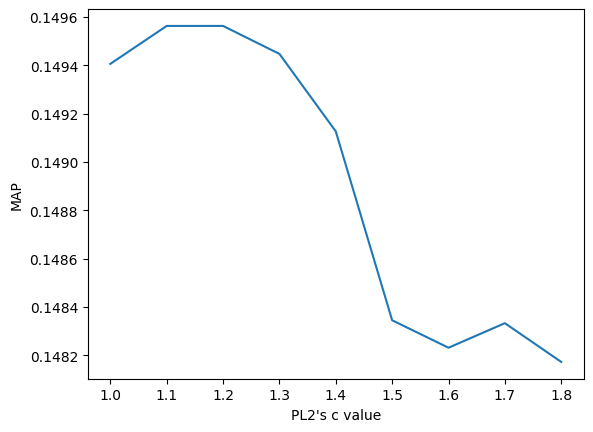

In [5]:
print(rtr)
plt.plot(rtr["tran_0_c"], rtr["map"])
plt.xlabel("PL2's c value")
plt.ylabel("MAP")
plt.show()

#### For retrieval with PL2 c=1.2 seems to work best

In [6]:
pl2 = pt.BatchRetrieve(indexer, wmodel="PL2", verbose=True, controls={"b" : 1.2})

#### Next, we want to experiment with query expansion for retrieval with BM25.

In [7]:
bm25 = pt.BatchRetrieve(indexer, wmodel="BM25", verbose=True, controls={"b" : 0.8})
#bm25= ~bm25

bo1_expansion = ~bm25 >> pt.rewrite.Bo1QueryExpansion(indexer)
bm25_bo1 = bo1_expansion >> bm25

kl = ~bm25 >> pt.rewrite.KLQueryExpansion(indexer)
bm25_kl = kl >> bm25

#### Additionally, we linearly combine retrieval with BM25 and PL2.

In [8]:
bm25_bo1_pl2 = (2* bm25_bo1 + pl2).transform(topics)
bm25_kl_pl2 = (2* bm25_kl + pl2).transform(topics)

BR(PL2): 100%|██████████| 882/882 [00:18<00:00, 46.59q/s]


#### Let's run an experiment, to see which retrieval model works best.

In [9]:
pt.Experiment(
    [~bm25, bm25_bo1, bm25_kl, bm25_bo1_pl2, bm25_kl_pl2], 
    topics, dataset.get_qrels(), 
    eval_metrics=["ndcg", "map", "recip_rank", "P_10", "recall_10"],
    names=["BM25", "BM25 >> Bo1 >> BM25", "BM25 >> KL >> BM25", "BM25 >> Bo1 >> BM25 w\ PL2", "BM25 >> KL >> BM25 w\ PL2"],
    baseline = 0
)

BR(BM25): 100%|██████████| 878/878 [00:24<00:00, 36.40q/s]


,name,map,recip_rank,P_10,recall_10,ndcg,map +,map -,map p-value,recip_rank +,...,recip_rank p-value,P_10 +,P_10 -,P_10 p-value,recall_10 +,recall_10 -,recall_10 p-value,ndcg +,ndcg -,ndcg p-value
0,BM25,0.154786,0.262879,0.093878,0.245990,0.310430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 >> Bo1 >> BM25,0.154537,0.247549,0.093764,0.245667,0.311638,387.0,385.0,0.938645,314.0,...,0.044073,94.0,108.0,0.954377,94.0,108.0,0.955848,398.0,374.0,0.702941
2,BM25 >> KL >> BM25,0.154457,0.245245,0.094444,0.247856,0.311413,406.0,364.0,0.911903,314.0,...,0.016136,103.0,105.0,0.775545,103.0,105.0,0.755227,411.0,359.0,0.747421
3,BM25 >> Bo1 >> BM25 w\ PL2,0.156717,0.252207,0.097279,0.254880,0.317847,420.0,351.0,0.461503,315.0,...,0.106075,98.0,80.0,0.059747,98.0,80.0,0.105873,439.0,332.0,0.005761
4,BM25 >> KL >> BM25 w\ PL2,0.155665,0.248064,0.096825,0.253491,0.316899,422.0,347.0,0.729945,304.0,...,0.021212,92.0,70.0,0.085092,92.0,70.0,0.149665,442.0,327.0,0.014464


#### The combination of BM25 with Bo1 query expansion and PL2 performs slightly better than the others. 

Next, we want to rerank the output with a transformer.

In [5]:
from pyterrier_t5 import MonoT5ReRanker
monoT5 = MonoT5ReRanker()

spiece.model: 100%|██████████| 792k/792k [00:00<00:00, 2.40MB/s]
tokenizer.json: 100%|██████████| 1.39M/1.39M [00:00<00:00, 3.33MB/s]
config.json: 100%|██████████| 1.21k/1.21k [00:00<00:00, 6.22MB/s]
/home/codespace/.python/current/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default l

In [7]:
import pandas as pd

corpus = pd.DataFrame(dataset.get_corpus_iter())


class GetText(pt.Transformer):
    def transform(self, topics_or_res: pd.DataFrame) -> pd.DataFrame:
        return pd.merge(topics_or_res, corpus, on="docno")

No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents:   6%|▌         | 3733/61307 [00:00<00:03, 18701.53it/s]

No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.
No settings given in /home/codespace/.tira/.tira-settings.json. I will use defaults.


ir-lab-jena-leipzig-wise-2023/validation-20231104-training documents: 100%|██████████| 61307/61307 [00:03<00:00, 16674.20it/s]


In [12]:
from pyterrier_t5 import T5Tokenizer

Rerank with transformer

In [18]:

bm25_bo1_pl2_monot5 = (bm25_bo1_pl2 % 100 >> GetText()
        >> pt.text.sliding(length=400, stride=64, prepend_attr=None, text_attr="text")
        >> monoT5 
        >> pt.text.max_passage()) 

In [19]:
print('Create run')
run = bm25_bo1_pl2_monot5(dataset.get_topics("text"))
print('Done, run was created')

Create run


BR(PL2): 100%|██████████| 1/1 [00:00<00:00, 14.49q/s]


calling sliding on df of 100 rows


monoT5: 100%|██████████| 214/214 [21:41<00:00,  6.08s/batches]

Done, run was created


### Step 4: Persist run.

In [8]:
persist_and_normalize_run(run, 't5-reranker')

I use the environment variable "TIRA_OUTPUT_DIR" to determine where I should store the run file using "." as default.
Done. run file is stored under "./run.txt".
